In [2]:
import json
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.style.use("ggplot")

def load_file(fname, cache={}):
    if fname in cache:
        return cache[fname]
    with open(fname, "r") as f:
        cache[fname] = json.load(f)
    return cache[fname]

FSRS-4.5
Num files: 19993
DASH
Num files: 19990
FSRSv4
Num files: 19993
FSRSv3
Num files: 19993
GRU
Num files: 19990
FSRS-4.5-dry-run
Num files: 19993


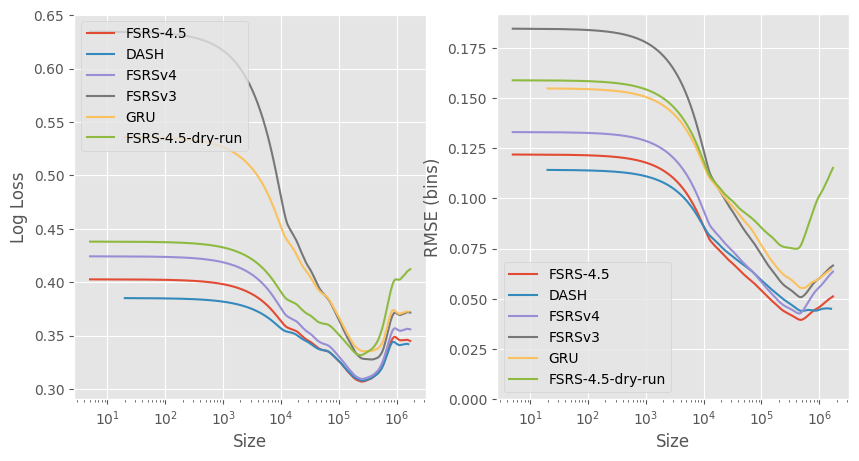

In [3]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for model in ["FSRS-4.5", "DASH", "FSRSv4", "FSRSv3", "GRU", "FSRS-4.5-dry-run"]:
    print(model)
    metrics = []
    sizes = []
    users = []
    RMSE_list = []
    LogLoss_list = []
    result_dir = pathlib.Path(f"../result/{model}")
    result_files = list(result_dir.glob("*.json"))
    print("Num files:", len(result_files))
    for result_file in result_files:
        result = load_file(result_file)
        sizes.append(result["size"])
        users.append(result["user"])
        metrics.append(result["metrics"])
        RMSE_list.append(result["metrics"]["RMSE(bins)"])
        LogLoss_list.append(result["metrics"]["LogLoss"])

    log_loss, size = zip(*sorted(zip(LogLoss_list, sizes), key=lambda x: x[1]))
    log_loss = lowess(
        log_loss, size, it=0, is_sorted=True, return_sorted=False
    )
    ax1.plot(size, log_loss, label=model)
    rmse_bins, size = zip(*sorted(zip(RMSE_list, sizes), key=lambda x: x[1]))
    rmse_bins = lowess(
        rmse_bins, size, it=0, is_sorted=True, return_sorted=False
    )
    
    ax2.plot(size, rmse_bins, label=model)

ax1.semilogx()
ax2.semilogx()
ax1.legend()
ax2.legend()
ax1.set_xlabel("Size")
ax1.set_ylabel("Log Loss")
ax2.set_xlabel("Size")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("RMSE (bins)")
plt.show()

FSRS-4.5-fullinfo
Num files: 21
FSRS-4.5-dry-run-fullinfo
Num files: 295


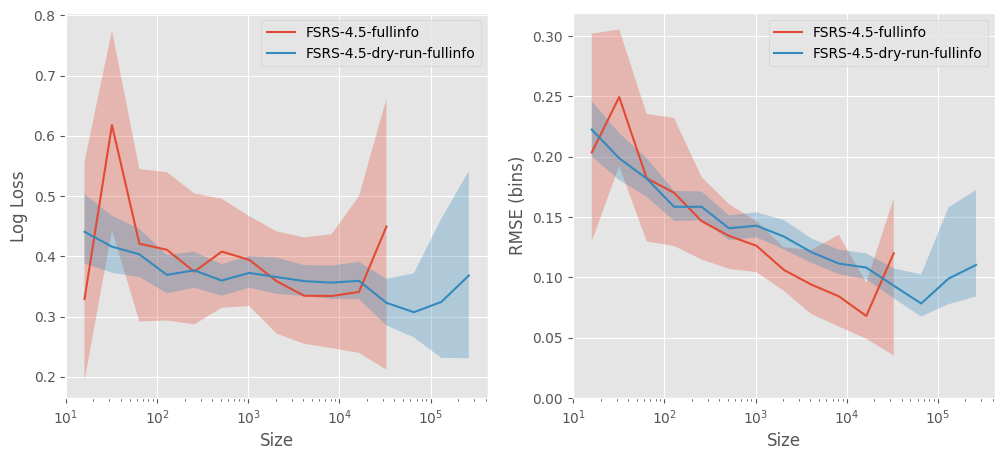

In [38]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for model in ["FSRS-4.5-fullinfo", "FSRS-4.5-dry-run-fullinfo"]:
    print(model)
    metrics = []
    sizes = []
    RMSE_list = []
    LogLoss_list = []
    result_dir = pathlib.Path(f"../result/{model}")
    result_files = list(result_dir.glob("*.json"))
    print("Num files:", len(result_files))
    if len(result_files) == 0:
        continue

    for result_file in result_files:
        result = load_file(result_file)
        sizes.extend(result["metrics"]["TrainSizes"])
        metrics.extend(result["metrics"])
        RMSE_list.extend(result["metrics"]["RMSE(bins)"])
        LogLoss_list.extend(result["metrics"]["LogLoss"])

    for this_losses, ax in zip([LogLoss_list, RMSE_list], [ax1, ax2]):
        # Get loss bins for each number of reviews known (called size)
        log_loss, size = zip(*sorted(zip(this_losses, sizes), key=lambda x: x[1]))
        log_loss = np.array(log_loss)
        size = np.array(size)
        size_unique = np.unique(size)
        log_loss_bins = [log_loss[size == s] for s in size_unique]

        # Remove any bins with less than 50 samples
        size_unique = [s for s, l in zip(size_unique, log_loss_bins) if len(l) >= 50]
        log_loss_bins = [l for l in log_loss_bins if len(l) >= 50]

        # Calculate 95% CI for each bin
        log_loss_bins_ci = [bootstrap((l,), np.mean, confidence_level=0.95, method="BCa").confidence_interval for l in log_loss_bins]

        # Plot means
        log_loss_means = [np.mean(l) for l in log_loss_bins]
        if len(size_unique) == 0: continue
        ax.plot(size_unique, log_loss_means, label=model)

        # Shade between confidence intervals
        log_loss_low = [l[0] for l in log_loss_bins_ci]
        log_loss_high = [l[1] for l in log_loss_bins_ci]
        ax.fill_between(size_unique, log_loss_low, log_loss_high, alpha=0.3)  #type: ignore

ax1.semilogx()
ax2.semilogx()
ax1.legend()
ax2.legend()
ax1.set_xlabel("Size")
ax1.set_ylabel("Log Loss")
ax2.set_xlabel("Size")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("RMSE (bins)")
plt.show()